##### This notebook examines the four main components of the air-sea heat flux in the abrupt experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

<Client: 'tcp://127.0.0.1:40067' processes=8 threads=8, memory=30.00 GiB>

In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# cc.querying.get_variables(session, experiment='1deg_jra55_ryf_cont')

In [5]:
expt = '1deg_jra55_ryf_cont'
var = 'temp_surface_ave'
SST_cont = cc.querying.getvar(expt, var, session)

In [6]:
# SST
yr_beg = '2400-01-01'
yr_end = '2410-12-31'
expt = '1deg_jra55_ryf_cont'
var = 'temp_surface_ave'
SST_cont = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end))#.groupby('time.year').mean('time')

expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp_surface_ave'
SST_warm = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end))#.groupby('time.year').mean('time')

expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp_surface_ave'
SST_cool = cc.querying.getvar(expt, var, session).sel(time = slice(yr_beg, yr_end))#.groupby('time.year').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [7]:
# stef_bolt = 5.670e-8
# sec_in_day = 86400
# # Q_lw = ((8 - 4 * stef_bolt * (SST_cont) ** 3 * (SST_warm - SST_cont)) * sec_in_year).sum(dim='year')
# # Q_lw = (((8 - stef_bolt * (SST_warm**4 - SST_cont**4)) * sec_in_year)).sum(dim='year') # give much the same value as above

# Q_lw_warm = ((8 - stef_bolt * ((SST_warm+273.15)**4 - (SST_cont+273.15)**4) * sec_in_day)).sum(dim='time')
# Q_lw_cool = ((-8 - stef_bolt * ((SST_cool+273.15)**4 - (SST_cont+273.15)**4) * sec_in_day)).sum(dim='time')

# Q_lw_warm.values
# Q_lw_cool.values

In [8]:
yr_beg = '2400-01-01'
yr_end = '2410-12-31'

def air_sea_fluxes(expt):
    sw = cc.querying.getvar(expt, 'swflx', session).sel(time = slice(yr_beg, yr_end))
    lw = cc.querying.getvar(expt, 'lw_heat', session).sel(time = slice(yr_beg, yr_end))
    sens = cc.querying.getvar(expt, 'sens_heat', session).sel(time = slice(yr_beg, yr_end))
    evap = cc.querying.getvar(expt, 'evap_heat', session).sel(time = slice(yr_beg, yr_end))
    total_flux = cc.querying.getvar(expt, 'net_sfc_heating', session).sel(time = slice(yr_beg, yr_end)) + cc.querying.getvar(expt, 'frazil_3d_int_z', session).sel(time = slice(yr_beg, yr_end))
    area = cc.querying.getvar(expt, 'area_t', session,n=1)
    return sw, lw, sens, evap, total_flux, area

def time_integrate(array):
    month_length = array.time.dt.days_in_month
    return (array * month_length * 24 * 3600).sum('time')

def NH_decomp(array):
    return array.sel(yt_ocean = slice(0, None))

def SH_decomp(array):
    return array.sel(yt_ocean = slice(None, 0))

In [9]:
expt = '1deg_jra55_ryf_cont'
fluxes_cont = air_sea_fluxes(expt)

expt = '1deg_jra55_ryf_RCPcool_humid_x1'
fluxes_cool = air_sea_fluxes(expt)

expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
fluxes_warm = air_sea_fluxes(expt)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [10]:
def integrate_fluxes(fluxes):
    whole_area = fluxes[-1]
    SH_area = whole_area.sel(yt_ocean = slice(0, None))
    NH_area = whole_area.sel(yt_ocean = slice(None, 0))
    fluxes_int_global = np.array([(time_integrate(fluxes[i]) * whole_area).sum(dim=('xt_ocean', 'yt_ocean')) for i in range(len(fluxes) - 1)]) # go to -1 since -1 is the area array
    fluxes_int_SH = np.array([(time_integrate(fluxes[i].sel(yt_ocean = slice(0, None))) * SH_area).sum(dim=('xt_ocean', 'yt_ocean')) for i in range(len(fluxes) - 1)])
    fluxes_int_NH = np.array([(time_integrate(fluxes[i].sel(yt_ocean = slice(None, 0))) * NH_area).sum(dim=('xt_ocean', 'yt_ocean')) for i in range(len(fluxes) - 1)])
    
    return np.array([fluxes_int_global, fluxes_int_SH, fluxes_int_NH])

In [11]:
integrate_fluxes_cont = integrate_fluxes(fluxes_cont)
integrate_fluxes_cool = integrate_fluxes(fluxes_cool)
integrate_fluxes_warm = integrate_fluxes(fluxes_warm)

distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


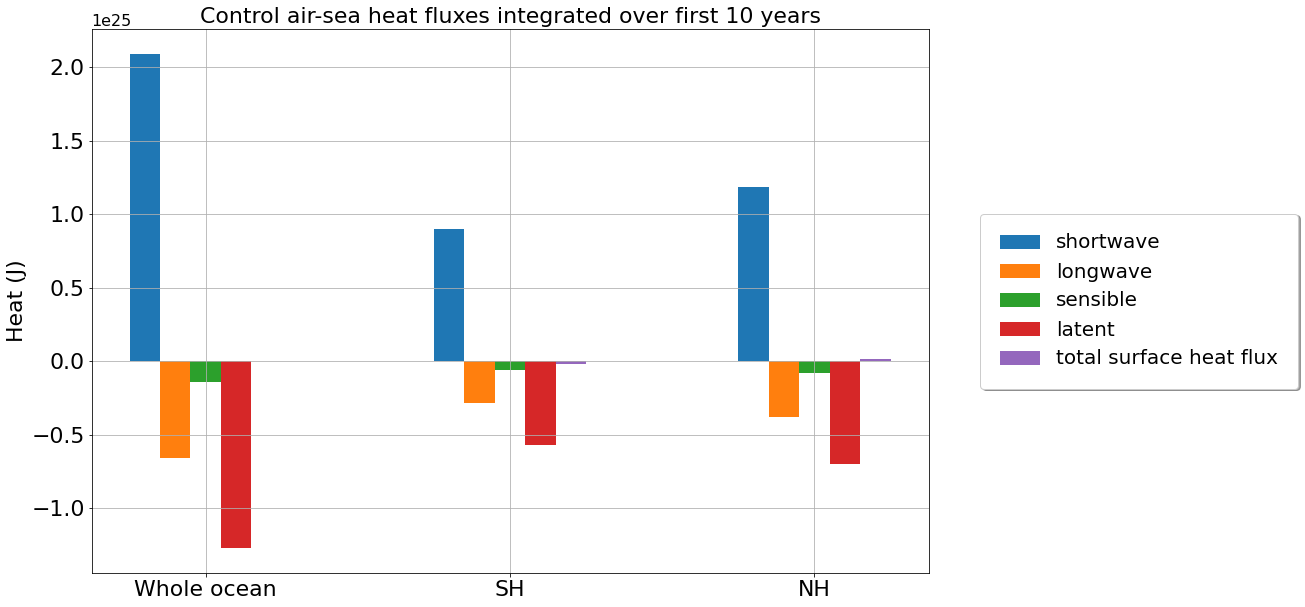

In [12]:
fig, ax = plt.subplots(figsize=(15,10))

X = np.arange(3)
data = integrate_fluxes_cont
plt.bar(X + 0.00, data[:,0], width = 0.1, label='shortwave')
plt.bar(X + 0.1, data[:,1], width = 0.1, label='longwave')
plt.bar(X + 0.2, data[:,2], width = 0.1, label='sensible')
plt.bar(X + 0.3, data[:,3], width = 0.1, label='latent')
plt.bar(X + 0.4, data[:,4], width = 0.1, label='total surface heat flux')

plt.xticks(X+0.2, ('Whole ocean', 'SH', 'NH'), fontsize=22)
plt.ylabel('Heat (J)', fontsize=22)
plt.yticks(fontsize=22)
ax.yaxis.get_offset_text().set_size(16)

plt.title('Control air-sea heat fluxes integrated over first 10 years', fontsize=22)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1.05, 0.5),loc = 'center left',labels=['shortwave', 'longwave', 'sensible', 'latent', 'total surface heat flux'], fontsize=20)
plt.grid()





# plt.savefig('air_sea_fluxes_control.jpg', bbox_inches='tight', dpi=100)

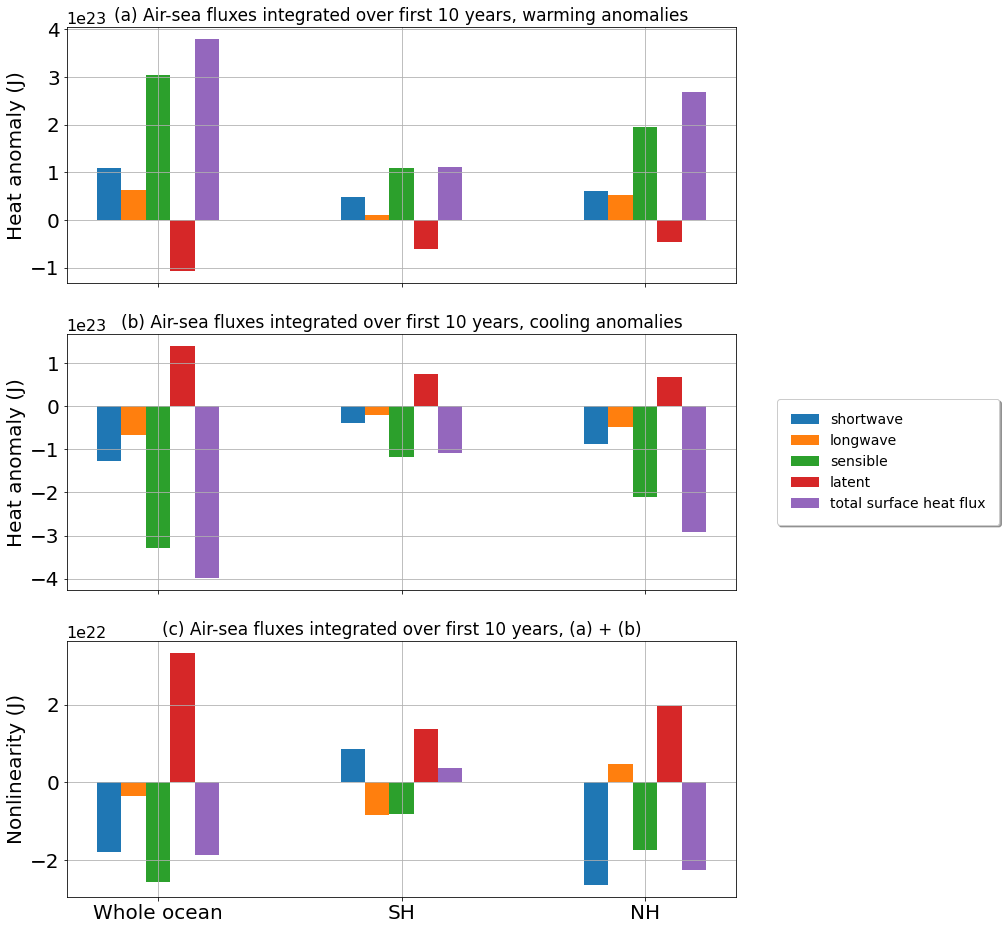

In [15]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize = (12,16), sharex = True)

X = np.arange(3)
# ymax = 6e13
# ymin = -4e13

def flux_bar_plot(data, title):
    ax.bar(X + 0.00, data[:,0], width = 0.1, label='shortwave')
    ax.bar(X + 0.1, data[:,1], width = 0.1, label='longwave')
    ax.bar(X + 0.2, data[:,2], width = 0.1, label='sensible')
    ax.bar(X + 0.3, data[:,3], width = 0.1, label='latent')
    ax.bar(X + 0.4, data[:,4], width = 0.1, label='total surface heat flux')
    ax.set_xticks(X+0.2)
    ax.set_ylabel('Heat anomaly (J)', fontsize=20)
    ax.yaxis.get_offset_text().set_size(16)
    ax.set_xticklabels(('Whole ocean', 'SH', 'NH'), fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(title, fontsize=17)
    ax.grid()    

ax = axs[0]
data = (integrate_fluxes_warm - integrate_fluxes_cont)
flux_bar_plot(data, '(a) Air-sea fluxes integrated over first 10 years, warming anomalies')
#ax.set_ylim(ymin, ymax)

ax = axs[1]
data = 1*(integrate_fluxes_cool - integrate_fluxes_cont)
flux_bar_plot(data, '(b) Air-sea fluxes integrated over first 10 years, cooling anomalies')
#ax.set_ylim(-ymax, -ymin)
#ax.set_ylim(ymin, ymax)
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1.05, 0.5),loc = 'center left',labels=['shortwave', 'longwave', 'sensible', 'latent', 'total surface heat flux'], fontsize=14)

ax = axs[2]
data = (((integrate_fluxes_warm - integrate_fluxes_cont) + (integrate_fluxes_cool - integrate_fluxes_cont)) / 1)
flux_bar_plot(data, '(c) Air-sea fluxes integrated over first 10 years, (a) + (b)') # $\\frac{a + b}{0.5 \\times (a + -1\\times b)}$
ax.set_ylabel('Nonlinearity (J)', fontsize=20)

fig.savefig('ApA_air_sea_fluxes.jpg', bbox_inches='tight', dpi=100)

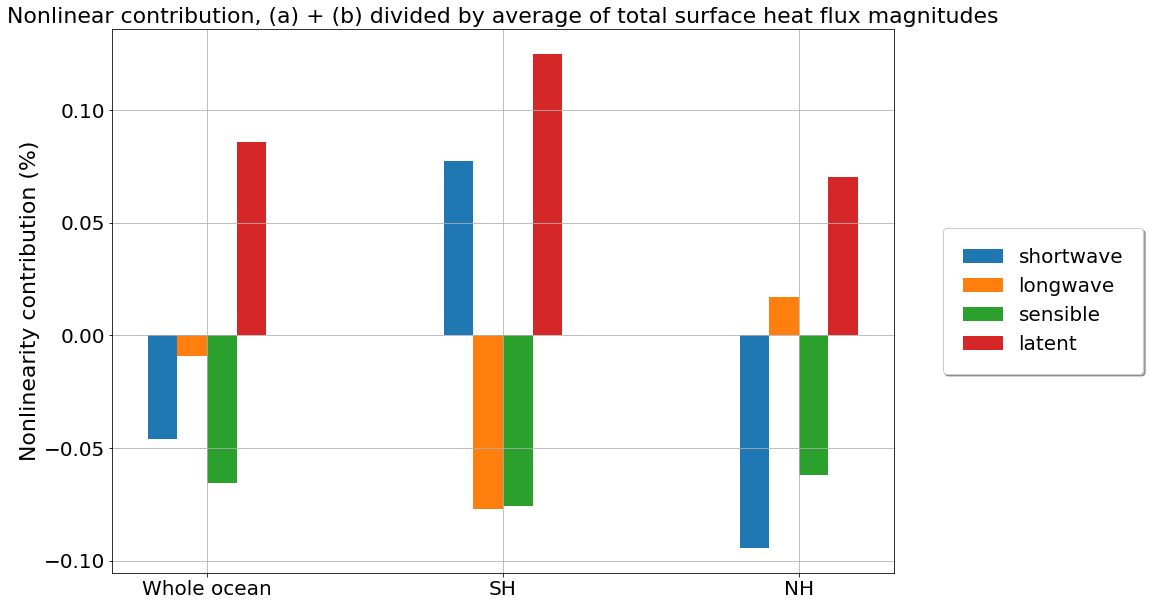

In [59]:
plt.figure(figsize=(14,10))

X = np.arange(3)

net_srf_flux_ave = (((integrate_fluxes_warm - integrate_fluxes_cont) + -1*(integrate_fluxes_cool - integrate_fluxes_cont)) / 2)[:, - 1] # ((integrate_fluxes_warm - integrate_fluxes_cont) + (integrate_fluxes_cool - integrate_fluxes_cont))[:, -1]
fluxes_nonlinear_contribution = ((integrate_fluxes_warm - integrate_fluxes_cont) + (integrate_fluxes_cool - integrate_fluxes_cont))
data = fluxes_nonlinear_contribution / net_srf_flux_ave[:, np.newaxis]

plt.bar(X + 0.00, data[:,0], width = 0.1, label='shortwave')
plt.bar(X + 0.1, data[:,1], width = 0.1, label='longwave')
plt.bar(X + 0.2, data[:,2], width = 0.1, label='sensible')
plt.bar(X + 0.3, data[:,3], width = 0.1, label='latent')
plt.xticks(X+0.15, ('Whole ocean', 'SH', 'NH'), fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Nonlinearity contribution (%)', fontsize=22)
plt.title('Nonlinear contribution, (a) + (b) divided by average of total surface heat flux magnitudes', fontsize=22)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1.05, 0.5),loc = 'center left',labels=['shortwave', 'longwave', 'sensible', 'latent', 'total surface heat flux'], fontsize=20)
plt.grid()
# plt.savefig('nonlinear_contribution_percentage.jpg')


### a) Divide the time-integrated air-sea heat flux anomalies by the time-integrated SST anomaly in each experiment, to see how much of the air-sea heat flux nonlinearity can be explained by the SST anomaly nonlinearity

In [102]:
SST_warm_anom = SST_warm - SST_cont
SST_cool_anom = SST_cool - SST_cont

SST_warm_anom_ave = SST_warm_anom.mean(dim='time').load()
SST_cool_anom_ave = SST_cool_anom.mean(dim='time').load()

ratio_SST_w_SST_c = (SST_warm_anom_ave/(-1*SST_cool_anom_ave)).values[0]

In [146]:
print(f'The ratio of the magnitudes of time-averaged SST_w and SST_c anomalies is {ratio_SST_w_SST_c - 1}')

The ratio of the magnitudes of time-averaged SST_w and SST_c anomalies is 0.02103006104653593


In [68]:
sw_warm_anom_ave = ((fluxes_warm[0] - fluxes_cont[0]) * fluxes_warm[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
lw_warm_anom_ave = ((fluxes_warm[1] - fluxes_cont[1]) * fluxes_warm[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
sens_warm_anom_ave = ((fluxes_warm[2] - fluxes_cont[2]) * fluxes_warm[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
lat_warm_anom_ave = ((fluxes_warm[3] - fluxes_cont[3]) * fluxes_warm[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
net_warm_anom_ave = ((fluxes_warm[4] - fluxes_cont[4]) * fluxes_warm[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()

sw_cool_anom_ave = ((fluxes_cool[0] - fluxes_cont[0]) * fluxes_cool[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
lw_cool_anom_ave = ((fluxes_cool[1] - fluxes_cont[1]) * fluxes_cool[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
sens_cool_anom_ave = ((fluxes_cool[2] - fluxes_cont[2]) * fluxes_cool[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
lat_cool_anom_ave = ((fluxes_cool[3] - fluxes_cont[3]) * fluxes_cool[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()
net_cool_anom_ave = ((fluxes_cool[4] - fluxes_cont[4]) * fluxes_cool[-1]).mean(dim=('xt_ocean', 'yt_ocean','time')).load()

In [147]:
ratio_SW_c_SW_w = float((sw_warm_anom_ave/(-1*sw_cool_anom_ave)).values)
ratio_LW_c_LW_w = float((lw_warm_anom_ave/(-1*lw_cool_anom_ave)).values)
ratio_SENS_c_SENS_w = float((sens_warm_anom_ave/(-1*sens_cool_anom_ave)).values)
ratio_LAT_c_LAT_w = float((lat_warm_anom_ave/(-1*lat_cool_anom_ave)).values)
ratio_NET_c_NET_w = float((net_warm_anom_ave/(-1*net_cool_anom_ave)).values)

ratio_SW_c_SW_w, ratio_LW_c_LW_w, ratio_SENS_c_SENS_w, ratio_LAT_c_LAT_w, ratio_NET_c_NET_w

print(f'{1 - ratio_SW_c_SW_w} = ratio of time-averaged SW_w and -1*SW_c anomalies')
print(f'{1 - ratio_LW_c_LW_w} =  ratio of time-averaged LW_w and -1*LW_c anomalies')
print(f'{1 - ratio_SENS_c_SENS_w} = ratio of time-averaged sens_w and -1*sens_c anomalies')
print(f'{1 - ratio_LAT_c_LAT_w} = ratio of time-averaged lat_w and -1*lat_c anomalies')
print(f'{1 - ratio_NET_c_NET_w} = ratio of time-averaged net_w and -1*net_c anomalies')

0.14611736695148303 = ratio of time-averaged SW_w and -1*SW_c anomalies
0.05202357361579357 =  ratio of time-averaged LW_w and -1*LW_c anomalies
0.07760325589023631 = ratio of time-averaged sens_w and -1*sens_c anomalies
0.23757946360803905 = ratio of time-averaged lat_w and -1*lat_c anomalies
0.04820150554738678 = ratio of time-averaged net_w and -1*net_c anomalies


In [121]:
# integrate_fluxes_warm_anom_global = (integrate_fluxes_warm - integrate_fluxes_cont)[0]
# integrate_fluxes_cool_anom_global = (integrate_fluxes_cool - integrate_fluxes_cont)[0]

# ratio_SW_c_SW_w = (-1*integrate_fluxes_cool_anom_global[0])/integrate_fluxes_warm_anom_global[0]
# ratio_LW_c_LW_w = (-1*integrate_fluxes_cool_anom_global[1])/integrate_fluxes_warm_anom_global[1]
# ratio_SENS_c_SENS_w = (-1*integrate_fluxes_cool_anom_global[2])/integrate_fluxes_warm_anom_global[2]
# ratio_LAT_c_LAT_w = (-1*integrate_fluxes_cool_anom_global[3])/integrate_fluxes_warm_anom_global[3]
# ratio_NET_c_NET_w = (-1*integrate_fluxes_cool_anom_global[4])/integrate_fluxes_warm_anom_global[4]

# ratio_SW_c_SW_w, ratio_LW_c_LW_w, ratio_SENS_c_SENS_w, ratio_LAT_c_LAT_w, ratio_NET_c_NET_w

# # print(f'The ratio of the magnitudes of time-averaged SST_w and SST_c anomalies is {(SST_warm_anom_ave/(-1*SST_cool_anom_ave)).values[0]}')

In [100]:
-1*net_cool_anom_ave / net_warm_anom_ave

<xarray.DataArray ()>
array(1.05064255)

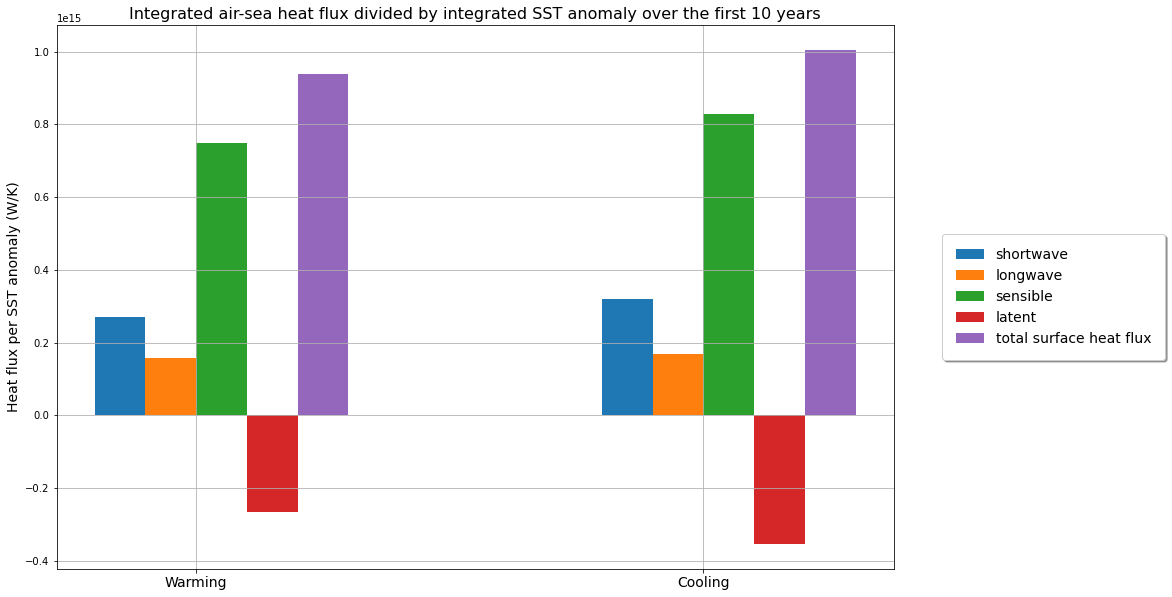

In [137]:
plt.figure(figsize=(15,10))

data_warming = (integrate_fluxes_warm[0] - integrate_fluxes_cont[0]) / SST_warm_anom_int.values
data_cooling = (integrate_fluxes_cool[0] - integrate_fluxes_cont[0]) / SST_cool_anom_int.values
data = np.vstack((data_warming, data_cooling))

X = np.arange(2)
plt.bar(X + 0.00, data[:,0], width = 0.1, label='shortwave')
plt.bar(X + 0.1, data[:,1], width = 0.1, label='longwave')
plt.bar(X + 0.2, data[:,2], width = 0.1, label='sensible')
plt.bar(X + 0.3, data[:,3], width = 0.1, label='latent')
plt.bar(X + 0.4, data[:,4], width = 0.1, label='total surface heat flux')
plt.xticks(X+0.15, ('Warming', 'Cooling'), fontsize=14)
plt.ylabel('Heat flux per SST anomaly (W/K)', fontsize=14)
plt.title('Integrated air-sea heat flux divided by integrated SST anomaly over the first 10 years', fontsize=16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1.05, 0.5),loc = 'center left',labels=['shortwave', 'longwave', 'sensible', 'latent', 'total surface heat flux'], fontsize=14)
plt.grid()
# plt.savefig('air_sea_fluxes_per_SST.jpg', bbox_inches='tight')

### b) Or, do I want to do the time-integral of (air-sea flux anomalies divided by the SST anomaly) in each experiment? Let's see how this differs from the above

In [161]:
def month_integrate(array):
    month_length = array.time.dt.days_in_month
    return (array * month_length * 24 * 3600)

def integrate_flux_per_SST(fluxes_anom, SST_anom):
    
    whole_area = fluxes[-1]
    
    fluxes_per_SST_int = np.array([np.sum(month_integrate(fluxes * whole_area).values / SST_anom.resample(time="1MS").mean(dim='time').values.squeeze()) \
                                   for i in range(len(fluxes) - 1)])

    return fluxes_per_SST_int

In [163]:
fluxes_warm_anom = fluxes_warm - fluxes_cont
fluxes_cool_anom = fluxes_cool - fluxes_cont
test2 = integrate_flux_per_SST(fluxes_warm_anom, SST_warm_anom)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [30]:
def area_weighted_ave(tracer, expt):
    lat_lower = float(tracer['yt_ocean'][0]) # so that this function will work when we have hemipsherically-decomposed
    lat_upper = float(tracer['yt_ocean'][-1])
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean=slice(lat_lower, lat_upper)).load() # area of cells
    area_total = area_t.sum(dim=('xt_ocean', 'yt_ocean')) # total area of ocean

    return (area_t * tracer).sum(dim=('xt_ocean', 'yt_ocean')) / area_total

def global_ave_fluxes(fluxes, expt):
    sw = area_weighted_ave(fluxes[0], expt)
    lw = area_weighted_ave(fluxes[1], expt)
    sens = area_weighted_ave(fluxes[2], expt)
    lat = area_weighted_ave(fluxes[3], expt)
    return sw, lw, sens, lat
    
expt = '1deg_jra55_ryf_cont'
global_ave_fluxes_cont = global_ave_fluxes(fluxes_cont, expt)